# FIREX-AQ 2 CMAQ
### Grid FIREX-AQ observations to CMAQ grid
### Aerosols from CU Boulder Aerosol Mass Spec

Inputs:
* FIREX-AQ data
* Met files
* GRIDDESC file

In [1]:
import PseudoNetCDF as pnc
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

/Users/jameseast/anaconda3/envs/jpy01/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# create a GRIDDESC
with open('GRIDDESC', 'w') as gf:
    gf.write(
       "' '\n'LamCon_40N_97W'\n 2 33.000 45.000 -97.000 -97.000 40.000\n" +
       "' '\n'12US1'\n'LamCon_40N_97W' " +
       "-2556000.0 -1728000.0 12000.0 12000.0 459 299 1\n' '"
    )

In [3]:
mygrid = '12US1'

In [4]:
gf = pnc.pncopen('GRIDDESC',format='griddesc',GDNAM=mygrid)

**PNC:/Users/jameseast/anaconda3/envs/jpy01/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  SDATE was -635; using 1970001
**PNC:/Users/jameseast/anaconda3/envs/jpy01/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF


In [5]:
# path, can read this from file/command line
pathtofxaq = '../data/ams/FIREXAQ-AMS-60s_DC8_20190724_R1.ict'

In [6]:
fxaq = pnc.pncopen(pathtofxaq,format='ffi1001')

In [7]:
pathtosmk = '../data/smoke_flag/firexaq-fire-Flags-1HZ_DC8_20190724_R9.ict'
smkf = pnc.pncopen(pathtosmk,format='ffi1001')

In [8]:
# list all variables and pick ones I want
keepv = []
for v in list(fxaq.variables.keys()):
    #if ('NO' in v) or ('O3' in v):
    if 'OA_PM' in v:
        print(v)
        keepv.append(v)
altitudevar = 'ALT_AMS_60s'
latvar = 'LAT_AMS_60s'
lonvar = 'LON_AMS_60s'
print(keepv)

OA_PM1_AMS_60s
['OA_PM1_AMS_60s']


In [9]:
smkf.variables['TIME_START'];

In [10]:
plumet = 10 # near plume minutes to exclude

In [11]:
#m3df = '/work/MOD3EVAL/jeast/NO2ASSIM/CMAQ/input/2019_hemi/mcip/METCRO3D_20190803.nc4'

#m3d = xr.open_dataset(m3df)

In [12]:
#sdate = pd.to_datetime(f'{m3d.SDATE}',format='%Y%j') # assumes STIME = 0
sdate = pd.to_datetime('2019-07-22')

In [13]:
dfx = pd.DataFrame()
dfx['time'] = sdate+pd.to_timedelta(fxaq.variables['Time_Mid'], unit='s')

In [14]:
dfx['time'] = dfx['time'].dt.round('1min')
dfx['lat'] = fxaq.variables[latvar].array()
dfx['lon'] = fxaq.variables[lonvar].array()
#dfx['smokeflag'] = fxaq.variables['Smoke_flag_SCHWARZ'].array()
dfx[f'altitude_{fxaq.variables[altitudevar].units}'] = fxaq.variables[altitudevar].array()
for v in keepv:
    dfx[f'{v}_{fxaq.variables[v].units}'] = fxaq.variables[v].array()

In [15]:
dfx['I'],dfx['J'] = gf.ll2ij(dfx['lon'],dfx['lat'])

**PNC:/Users/jameseast/anaconda3/envs/jpy01/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF


In [16]:
dfx['T'] = np.array([(t - sdate).total_seconds() // 3600 for t in dfx['time']], dtype='i')

In [17]:
dfxd = dfx.query('T >= 0 and T <= 23').copy(deep=True)

In [18]:
alt_bin_edges = np.arange(0,np.ceil(dfxd.altitude_m.max()/1000)*1000+1,1000)

In [20]:
dfxd['K'] = np.ma.masked_less(
    alt_bin_edges[1:] - dfxd['altitude_m'].to_numpy()[:,None],0
).argmin(1)

In [35]:
dfgrid = dfxd.groupby([
    'T','K','J','I'
]).agg(np.nanmean).drop('altitude_m',axis=1).reset_index().dropna()
    

In [36]:
# Make data the shape of an ioapi file

blankij=pd.DataFrame(
    np.zeros((
        np.arange(0,24,dtype=int).shape[0] *
        np.arange(0,alt_bin_edges.shape[0]-1,dtype=int).shape[0] *
        np.arange(0,len(gf.dimensions['ROW']),dtype=int).shape[0] *
        np.arange(0,len(gf.dimensions['COL']),dtype=int).shape[0]
    )),
    columns=['blank'],
    index=pd.MultiIndex.from_product(
        [
            np.arange(0,24,dtype=int),
            np.arange(0,alt_bin_edges.shape[0]-1,dtype=int),
            np.arange(0,len(gf.dimensions['ROW']),dtype=int),
            np.arange(0,len(gf.dimensions['COL']),dtype=int)
        ],
        names=['T','K','J','I']
    ),
)

In [59]:
dfout = (
    blankij.drop(['blank'],axis='columns')
).merge(
    dfgrid,
    how='outer',
    left_index=True,
    right_on=['T','K','J','I']
)
dfout_idx = dfout.groupby(['T','K','J','I']).first()
dout = dfout_idx.to_xarray()

In [60]:
dout = dout.rename({'T':'TSTEP', 'K':'LAY', 'J':'ROW', 'I':'COL'})

In [61]:
dout = dout.rename({'OA_PM1_AMS_60s_ug sm-3': 'OA'})
dout['OA'].attrs['units'] = 'ug m3'

In [76]:
proj = pyproj.Proj('+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=33 +lat_2=45 +R=6370000 +no_defs')
cno = pycno.cno(proj=proj,xlim=(0, 396), ylim=(0, 246))

In [82]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

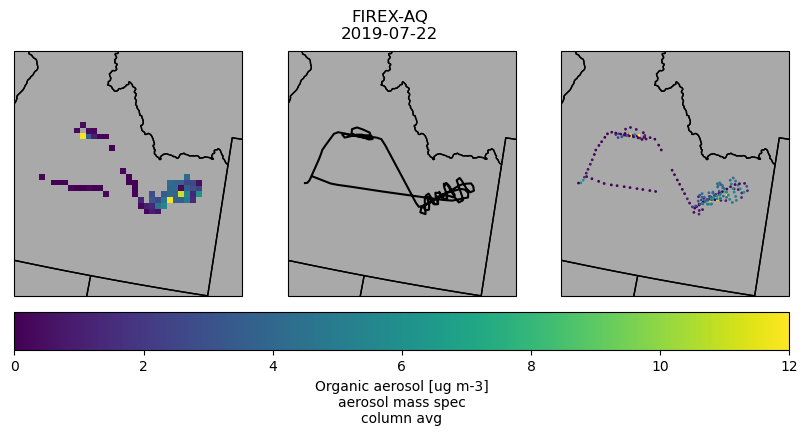

In [140]:
fig,axs = plt.subplots(
    1,3,
    subplot_kw={
        'projection':ccrs.LambertConformal(
            central_longitude=-97.0,
            central_latitude=40.0
        )
    },
    figsize=(10,4)
)

ax=axs[0]
pc = ax.pcolormesh(
    gf.variables['longitude'],
    gf.variables['latitude'],
    dout['OA'].mean(('TSTEP','LAY')),
    transform=ccrs.PlateCarree(),
    vmin=0, vmax=12
)



ax=axs[1]
ax.plot(
    fxaq.variables[lonvar],
    fxaq.variables[latvar],
    transform=ccrs.PlateCarree(),
    color='k'
)

ax=axs[2]
ax.scatter(
    fxaq.variables[lonvar],
    fxaq.variables[latvar],
    transform=ccrs.PlateCarree(),
    c=fxaq.variables['OA_PM1_AMS_60s'],
    s=1,
    vmin=0, vmax=12
)

for ax in axs:
    ax.add_feature(cfeature.STATES)
    ax.set_facecolor('darkgrey')
    ax.coastlines()
    ax.set_extent((-116,-111,42,46))

fig.colorbar(pc, ax=axs, label='Organic aerosol [ug m-3]\naerosol mass spec\ncolumn avg',orientation='horizontal',pad=0.05)
fig.suptitle(f'FIREX-AQ\n{sdate.strftime("%Y-%m-%d")}')
fig.savefig('firexaq_oa.png',dpi=600,bbox_inches='tight')